In [1]:
# from circuit_breaking.src import *
%load_ext autoreload
%autoreload 2
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
print(os.getcwd())
import sys
from transformers import AutoTokenizer, AutoModelForCausalLM

/data/phillip_guo/mechanistic-unlearning


In [2]:
model_name_or_path = "google/gemma-2-9b-it"
model_type = "gemma-2"
other_model_type = "gemma2_9b"
pretrained_path = "/data/huggingface/models--google--gemma-2-9b/snapshots/33c193028431c2fde6c6e51f29e6f17b60cbfac6/"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b-it/snapshots/11c9b309abf73637e4b6f9a3fa1e92e615547819/"


tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

left_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
left_tokenizer.padding_side = "left"

if pretrained_path is not None:
    model = AutoModelForCausalLM.from_pretrained(pretrained_path, torch_dtype=torch.bfloat16)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)
model.cuda()
n_layers = 42
n_heads = 16
n_kv_heads = 8

param_count_dict = {"attn.hook_q": 3584*4096, "attn.hook_k": 3584*2048, "attn.hook_v": 3584*2048, "attn.hook_result": 4096*3584, "mlp.hook_pre": 3584 * 14336, "mlp.hook_post": 14336 * 3584, "mlp.hook_gate": 3584 * 14336}
mmlu_batch_size = 2

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
from tasks.wmdp.WMDP_MCTask import WMDP_MCTask
from tasks.wmdp.WMDP_RelearnTask import WMDP_RelearnTask
batch_size = 16
bio_mc_task = WMDP_MCTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True)
print(bio_mc_task.dataset)

Dataset({
    features: ['answer', 'question', 'choices', 'prompt'],
    num_rows: 1273
})


In [4]:
# acc = 0
# n_iters = len(bio_mc_task.dataset) // batch_size
# for i in tqdm(range(n_iters)):
#     acc += bio_mc_task.get_test_accuracy(model)
# acc /= n_iters
# acc

print("Accuracy for Gemma 2 9B: 72%")


Accuracy for Gemma 2 9B: 72%


## Find Relevant SAE Features

In [5]:
bio_ce_task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True)
display(bio_ce_task.df)

from tasks.general.DatasetTasks import PileTask
pile_task = PileTask(batch_size=batch_size, tokenizer=tokenizer, stream_dataset=True, buffer_size=10000, ctx_length=500)
print(pile_task.get_batch())

,title,abstract,text,doi
0,Transmission potential and severity of COVID-1...,Highlights\nCOVID-19 caused 6284 cases and 42 ...,Introduction\nA novel coronavirus (SARS-CoV-2)...,10.1016/j.ijid.2020.03.031
1,Two Ligand-Binding Sites on SARS-CoV-2 Non-Str...,The regular reappearance of coronavirus (CoV) ...,"1. Introduction\nIn the past two decades, coro...",10.3390/ijms232012448
2,Protective Efficacy of Rhesus Adenovirus COVID...,The global COVID-19 pandemic has sparked inten...,INTRODUCTION\nA critical component of the eval...,10.1128/JVI.00974-21
3,Hand hygiene during COVID-19: Recommendations ...,The recent COVID-19 pandemic has resulted in i...,Capsule Summary\nHand hygiene is an accepted p...,10.1016/j.jaad.2020.07.057
4,Genome-wide CRISPR Screens Reveal Host Factors...,Identification of host genes essential for sev...,Introduction\nSevere acute respiratory syndrom...,10.1016/j.cell.2020.10.028
...,...,...,...,...
24448,Serum reactome induced by Bordetella pertussis...,Background\nPertussis (whooping cough) remains...,Background\nPertussis (whooping cough) caused ...,10.1186/s12865-015-0090-3
24449,Asymptomatic transmission and the resurgence o...,Background\nThe recent increase in whooping co...,Background\nMany countries have seen a startli...,10.1186/s12916-015-0382-8
24450,Depletion of Regulatory T Cells Augments a Vac...,Regulatory T cells (Treg) have been shown to r...,Introduction\nThe liver stage of malaria is an...,10.1371/journal.pone.0104627
24451,Global Population Structure and Evolution of B...,"Bordetella pertussis causes pertussis, a respi...",INTRODUCTION\nBordetella pertussis is the prim...,10.1128/mBio.01074-14


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
{'text': ['It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great

In [6]:
from sae_lens import SAE

width_131k_sae_dict = {}
width_16k_sae_dict = {}

sae_layers = [21]
# 3.76 gb + .47 gb = 4.23 gb
for layer in tqdm(sae_layers):
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
        sae_id = f"layer_{layer}/width_131k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
    )
    width_131k_sae_dict[f"layer_{layer}"] = sae
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
        sae_id = f"layer_{layer}/width_16k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
    )
    width_16k_sae_dict[f"layer_{layer}"] = sae


  0%|          | 0/1 [00:00<?, ?it/s]

### Replicate SAE Unlearning feature selection

In [7]:
def gather_residual_activations(model, target_layers, input_ids, attention_mask=None, unmasked_for_sae=False):
  output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
  hidden_states = output.hidden_states
  # hidden state has n_layers + 1 elements, the first one is the embeddings
  # so need to add one to the target layer to get the correct layer
  if isinstance(target_layers, int):
    target_layers = [target_layers]

  layer_hidden_states = []
  for layer in target_layers:
    layer_hidden_states.append(hidden_states[layer+1])
  layer_hidden_states = torch.stack(layer_hidden_states)
  if unmasked_for_sae:
    assert attention_mask is not None, "Must provide attention mask for flat return"

    # layer hidden states should be shape (n_layers, batch_size, seq_len, hidden_size)
    # attention_mask should be shape (batch_size, seq_len)
    assert layer_hidden_states.shape[1] == attention_mask.shape[0], f"Batch size mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert layer_hidden_states.shape[2] == attention_mask.shape[1], f"Sequence length mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert len(layer_hidden_states.shape) == 4 and len(attention_mask.shape) == 2, f"Layer hidden states and attention mask must be 4D and 2D respectively but got {layer_hidden_states.shape} and {attention_mask.shape}"
    batch_indices, seq_indices = torch.where(attention_mask[:, 1:])
    layer_hidden_states = layer_hidden_states[:, :, 1:, :]
    return layer_hidden_states[:, batch_indices, seq_indices, :]

  else:
    return layer_hidden_states

  # target_act = None
  # def gather_target_act_hook(mod, inputs, outputs):
  #   nonlocal target_act # make sure we can modify the target_act from the outer scope
  #   target_act = outputs[0]
  #   return outputs
  # handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  # _ = model.forward(**inputs)
  # handle.remove()
  # return target_act

In [8]:
batch = pile_task.get_batch()["text"]
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=200)
inputs = {k: v.cuda() for k, v in inputs.items()}
print(inputs["input_ids"].shape)
print(inputs["attention_mask"].sum())


with torch.no_grad():
    target_act = gather_residual_activations(model, 21, **inputs, unmasked_for_sae=True)[0]
print(target_act.shape)


sae = width_131k_sae_dict[f"layer_{21}"]
if next(sae.parameters()).device.type != "cuda":
    sae = sae.cuda()
with torch.amp.autocast(device_type="cuda"):
    sae_acts = sae.encode(target_act)
print(sae_acts.shape)


recon = sae.decode(sae_acts)
with torch.no_grad():
    if len(sae_acts.shape) == 2:
        print(1 - torch.mean((recon - target_act.to(torch.float32)) **2) / (target_act.to(torch.float32).var()))
    else:
        print(1 - torch.mean((recon[..., 1:] - target_act[..., 1:].to(torch.float32)) **2) / (target_act[..., 1:].to(torch.float32).var()))

torch.Size([16, 200])
tensor(2939, device='cuda:0')


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


torch.Size([2923, 3584])
torch.Size([2923, 131072])
tensor(0.9195, device='cuda:0')


In [35]:
def get_sae_acts(model, sae, task, n_batches=10, ctx_len=500, text_key="text", return_tokens=True):
    all_sae_acts = []
    for batch_idx in tqdm(range(n_batches)):
        batch = task.get_batch()[text_key]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=ctx_len)
        inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            target_act = gather_residual_activations(model, 21, **inputs, unmasked_for_sae=True)[0]
            with torch.amp.autocast(device_type="cuda"):
                sae_acts = sae.encode(target_act)
        all_sae_acts.append(sae_acts.cpu())
    return torch.cat(all_sae_acts, dim=0)

sae = width_16k_sae_dict[f"layer_{21}"]
if next(sae.parameters()).device.type != "cuda":
    sae = sae.cuda()


pile_sae_acts = get_sae_acts(model, sae, pile_task, n_batches=10, ctx_len=500, text_key="text")
print(pile_sae_acts.shape)

bio_sae_acts = get_sae_acts(model, sae, bio_ce_task, n_batches=10, ctx_len=500, text_key="abstract")
print(bio_sae_acts.shape)


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([55661, 16384])


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([50591, 16384])


In [50]:
bio_ce_task.get_batch()["abstract"]

['The idiotype network is experimentally modified to provide protective immunity against various microbial pathogens. Both internal and non-internal image-idiotype antibodies can trigger specific immune responses to antigens. The current outbreak of Severe Acute Respiratory Syndrome 2 (SARS-2) has provided a great opportunity to take advantage of idiotype / anti-idiotype antibodies as a protective regimen when no approved vaccine is available on earth. The current review identifies successful applications of idiotype/ anti-idiotype antibodies in various viral diseases and highlights their importance in COVID-19 pandemics. In the absence of vaccines and targeted therapies, polyclonal idiotype/ anti-idiotype antibodies against the viral structure may be a potential approach to the prevention and treatment of COVID-19 patients.',
 'Oral mucosal lesions that are associated with HIV infection can play an important role in guiding the decision to initiate antiretroviral therapy (ART). The in

In [51]:
bio_sae_acts

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [52]:
# which features have sparsity > 0.01 on pile?
pile_mask = (pile_sae_acts > 0).float().mean(dim=0) <= 0.01

# multiply by mask so that we filter out all features that are also common on pile
bio_sparsities = (bio_sae_acts > 0).float().mean(dim=0) * pile_mask

# rank indices by sparsity
bio_sparsities_sorted = bio_sparsities.sort(descending=True)
bio_sparsities_sorted

torch.return_types.sort(
values=tensor([0.3235, 0.1463, 0.1237,  ..., 0.0000, 0.0000, 0.0000]),
indices=tensor([4946, 9715, 8989,  ..., 8580, 8575, 8568]))

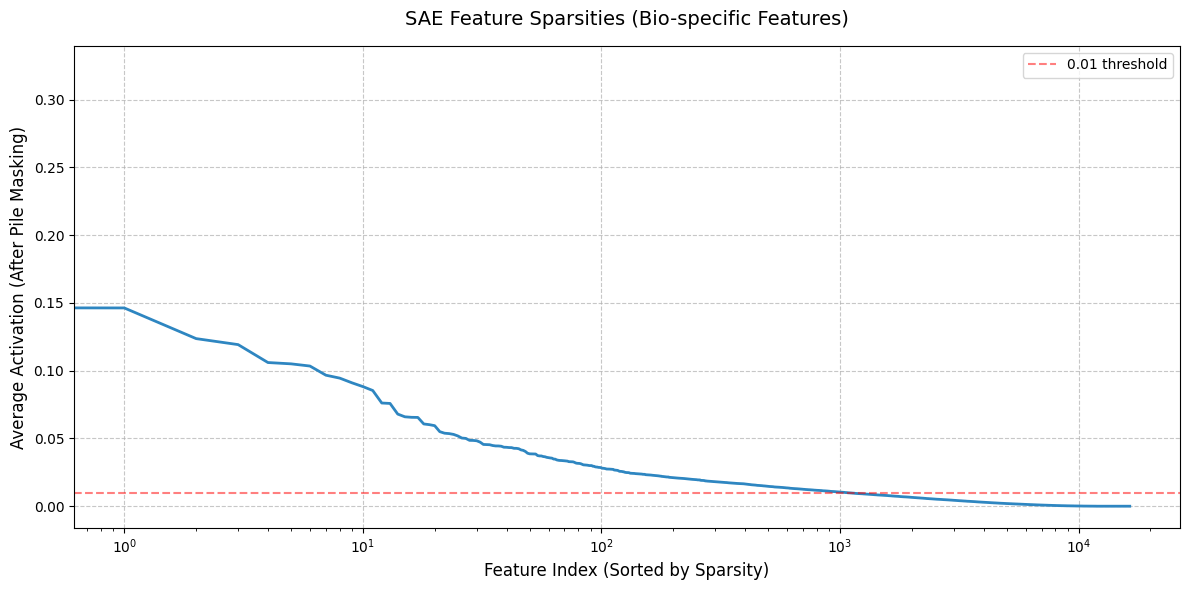

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(bio_sparsities_sorted.values, linewidth=2, color='#2E86C1')

plt.title('SAE Feature Sparsities (Bio-specific Features)', fontsize=14, pad=15)
plt.xlabel('Feature Index (Sorted by Sparsity)', fontsize=12)
plt.ylabel('Average Activation (After Pile Masking)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
# plt.yscale('log')  # Log scale often helps visualize sparsity patterns better
plt.xscale('log')

# Add a horizontal line at 0.01 for reference
plt.axhline(y=0.01, color='r', linestyle='--', alpha=0.5, label='0.01 threshold')

plt.legend()
plt.tight_layout()

In [54]:
print(bio_sparsities_sorted.indices[:10])

tensor([ 4946,  9715,  8989, 10496, 12231, 13060,  3179,  3300,  6620,  6718])


### Visualize SAE Features

In [59]:
from IPython.display import IFrame
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

# 'The idiotype network is experimentally modified to provide protective immunity against various microbial pathogens. Both internal and non-internal image-idiotype antibodies can trigger specific immune responses to antigens. The current outbreak of Severe Acute Respiratory Syndrome 2 (SARS-2) has provided a great opportunity to take advantage of idiotype / anti-idiotype antibodies as a protective regimen when no approved vaccine is available on earth. The current review identifies successful applications of idiotype/ anti-idiotype antibodies in various viral diseases and highlights their importance in COVID-19 pandemics. In the absence of vaccines and targeted therapies, polyclonal idiotype/ anti-idiotype antibodies against the viral structure may be a potential approach to the prevention and treatment of COVID-19 patients.'
 
def get_dashboard_html(sae_release = "gemma-2-9b", sae_id="21-gemmascope-res-16k", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gemma-2-9b", sae_id="21-gemmascope-res-131k", feature_idx=4946)
print(html)
IFrame(html, width=1200, height=600)

https://neuronpedia.org/gemma-2-9b/21-gemmascope-res-131k/4946?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


## RMU

## Circuit Breakers